In [1]:
# nHP = 5, nSN = 20, time limit: 3600

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [3]:
model = gp.Model("DroneDataCollection")

In [4]:

nHP = 30  
nSN = 100 
M   = 5  

I = range(nHP) 
J = range(nSN)   


snp = np.random.rand(nSN, 2) * 1000

In [5]:

y  = model.addVars(I, J, vtype=GRB.BINARY, name="y")                   
h  = model.addVars(nHP, 2, vtype=GRB.CONTINUOUS, name="h")              
d1 = model.addVars(nHP, nSN, vtype=GRB.CONTINUOUS, name="Distance")     
bh = model.addVars(nHP, vtype=GRB.BINARY, name="bh")                   

d2 = model.addVars(nHP, nHP, vtype=GRB.CONTINUOUS, name="Distance")    
tx = model.addVars(nHP, nHP, vtype=GRB.BINARY, name="tx")
u  = model.addVars(nHP, vtype=GRB.CONTINUOUS)

In [6]:

for i in range(nHP):        
    for j in range(nSN):  
        model.addConstr(d1[i, j] >=   h[i, 0] - snp[j, 0] - 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >= -(h[i, 0] - snp[j, 0])- 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >=   h[i, 1] - snp[j, 1] - 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >= -(h[i, 1] - snp[j, 1])- 1000 * (1-y[i,j]))


for i in range(nHP):
    for j in range(nHP):
        if (i == j):
            model.addConstr(d2[i, j] >= 1000*1000)
        else:
            model.addConstr(d2[i, j] >=   h[i, 0] - h[j, 0] - 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >= -(h[i, 0] - h[j, 0])- 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >=   h[i, 1] - h[j, 1] - 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >= -(h[i, 1] - h[j, 1])- 2000 * (2-bh[i]-bh[j]))


In [7]:

model.addConstrs(h[i, 0] >=    0 for i in I)
model.addConstrs(h[i, 0] <= 1000 for i in I)
model.addConstrs(h[i, 1] >=    0 for i in I)
model.addConstrs(h[i, 1] <= 1000 for i in I)
pass

In [8]:

model.addConstrs((gp.quicksum(y[i, j] for i in I) == 1 for j in J), "SensingNodeCoverage")

model.addConstrs((gp.quicksum(y[i, j] for j in J) <= M * bh[i] for i in I), "MaxCoveredSensorsPerHoveringPoint")

pass

In [9]:

model.addConstrs((gp.quicksum(tx[i, j] for i in I) == bh[j] for j in I), "TSPConstr1")
model.addConstrs((gp.quicksum(tx[i, j] for j in I) == bh[i] for i in I), "TSPConstr2")
tHP = gp.quicksum(bh[i] for i in I)
for i in range(1, nHP):  
    for j in range(1, nHP): 
        if(i!=j):
            model.addConstr((u[i]-u[j]+tHP*tx[i,j])<=tHP-1)
pass

In [10]:
x1 = gp.quicksum( y[i, j]*d1[i, j] for i in I for j in J) 
x2 = gp.quicksum(tx[i, j]*d2[i, j] for i in I for j in I)  
model.setObjective(x1 + x2, GRB.MINIMIZE)  

In [11]:
data = {'objbnds': [], 'objbsts': [], 'objbstsols': [], 'times': [], 'times_mipsol': []}
def collect_data(model, where):
    if where == gp.GRB.Callback.MIPNODE:

        objbnd = model.cbGet(gp.GRB.Callback.MIPNODE_OBJBND)

        objbst = model.cbGet(gp.GRB.Callback.MIPNODE_OBJBST)

        data['objbnds'].append(objbnd)
        data['objbsts'].append(objbst)
        data['times'].append(model.cbGet(gp.GRB.Callback.RUNTIME))
    
    elif where == gp.GRB.Callback.MIPSOL:

        objbstsol = model.cbGet(gp.GRB.Callback.MIPSOL_OBJ)

        data['objbstsols'].append(objbstsol)
        data['times_mipsol'].append(model.cbGet(gp.GRB.Callback.RUNTIME))

In [12]:
model.params.TimeLimit = 3600
model.optimize(collect_data)

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 15820 rows, 7920 columns and 61440 nonzeros
Model fingerprint: 0x6deaabc4
Model has 3900 quadratic objective terms
Model has 812 quadratic constraints
Variable types: 3990 continuous, 3930 integer (3930 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
  QRHS range       [1e+00, 1e+00]
Presolve added 1474 rows and 0 columns
Presolve removed 0 rows and 31 columns
Presolve time: 0.11s
Presolved: 25034 rows, 19499 columns, 109060 nonzeros
Presolved model has 7740 SOS constraint(

In [13]:

num_vars = model.NumVars
print(f"Number of variables: {num_vars}")

num_constrs = model.NumConstrs
print(f"Number of constraints: {num_constrs}")

m_optimal = model.status == GRB.OPTIMAL
print(f"Is optimal: {m_optimal}")

Number of variables: 7920
Number of constraints: 15820
Is optimal: False


In [14]:
res_h = np.zeros([nHP, 2])
for i in range(nHP):
    res_h[i, 0] = h[i, 0].X
    res_h[i, 1] = h[i, 1].X
res_bh = np.array([bh[i].X for i in I])

In [15]:
# tsp_dict
tsp_dict = { (i, j): 0 for i in I for j in I }
for i in I:
    for j in I:
        value = model.getVarByName(f"tx[{i},{j}]").x
        tsp_dict[(i, j)] = value

# tans_dict
tans_dict = { (i, j): 0 for i in I for j in J }
for i in I:
    for j in J:
        value = model.getVarByName(f"y[{i},{j}]").x
        tans_dict[(i, j)] = value


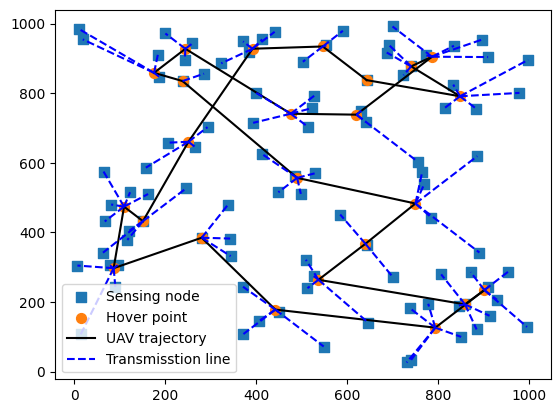

In [17]:
import matplotlib.pylab as plt

res_h2 = res_h[res_bh.astype(bool)]
plt.scatter(snp[:, 0], snp[:, 1], marker='s', s=50, label='Sensing node')
plt.scatter(res_h2[:, 0], res_h2[:, 1], marker='o', s=50, label='Hover point')

route = [key for key,value in tsp_dict.items() if value == 1]
for r in route:
    plt.plot([res_h[r[0],0], res_h[r[1],0]], [res_h[r[0],1], res_h[r[1],1]], 'k-')
line, = plt.plot([], [], 'k-', label="UAV trajectory")

tansr = [key for key,value in tans_dict.items() if value == 1]
for r in tansr:
    plt.plot([res_h[r[0],0], snp[r[1],0]], [res_h[r[0],1], snp[r[1],1]], 'b--')
line, = plt.plot([], [], 'b--', label='Transmisstion line')
plt.legend()
plt.show()

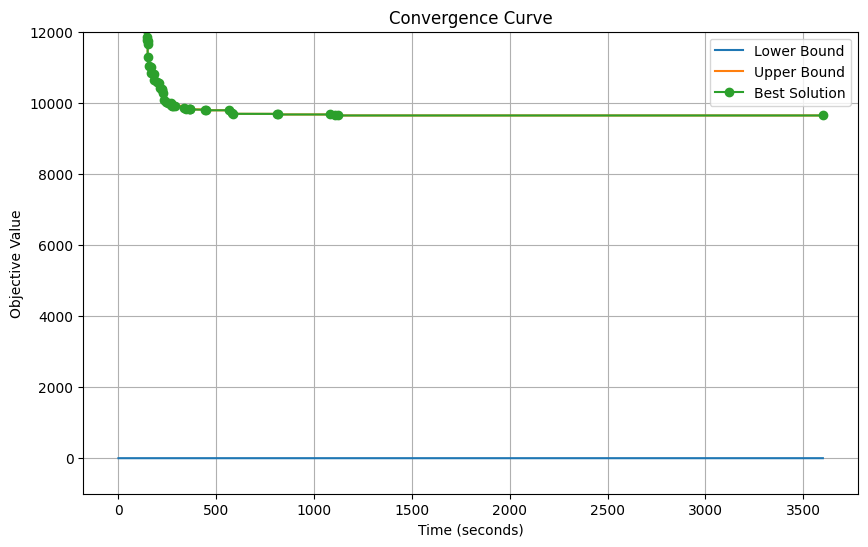

In [29]:

plt.figure(figsize=(10, 6))


plt.plot(data['times'], data['objbnds'], label='Lower Bound')


plt.plot(data['times'], data['objbsts'], label='Upper Bound')


plt.plot(data['times_mipsol'], data['objbstsols'], label='Best Solution', marker='o')

plt.xlabel('Time (seconds)')
plt.ylabel('Objective Value')
plt.title('Convergence Curve')
plt.legend()
plt.grid(True)
plt.ylim([-1000, 12000])
plt.show()

In [19]:
snp

array([[371.08006671, 948.54295526],
       [910.3763495 , 903.76250022],
       [186.26218195, 847.34901985],
       [449.28301511, 171.11256061],
       [700.02625636, 991.61849534],
       [ 95.22671736, 306.23050465],
       [498.17933156, 510.65867433],
       [399.98410225, 800.77419536],
       [584.84122608, 451.42127462],
       [323.05604066, 885.75722308],
       [785.58925252, 442.70453753],
       [646.48707242, 140.9182894 ],
       [755.13442363, 603.65581053],
       [200.07732328, 971.53504014],
       [833.58093622, 824.69835763],
       [554.45687856, 937.08691452],
       [122.36137413, 515.41264795],
       [740.93906481, 877.02897394],
       [513.31727317, 703.74727232],
       [512.8276656 , 239.80785216],
       [116.35745389, 378.40174247],
       [265.64802551, 645.43717257],
       [731.05064411,  26.4034541 ],
       [342.66956147, 382.4190023 ],
       [995.92435185, 128.60146139],
       [  9.58491721, 984.55576596],
       [886.42508325, 618.99679318],
 

In [20]:

count = 0

for i in I:
    row = [round(tans_dict[(i, j)]) for j in J]
    count += sum(row)
    print(row, sum(row))
print(count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:

count = 0

for i in I:
    row = [round(tsp_dict[(i, j)]) for j in I]
    count += sum(row)
    print(row, sum(row))
print(count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 1
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [22]:

res_h

array([[280.06335392, 384.78292289],
       [280.06335392, 384.78292289],
       [848.44738492, 791.15566175],
       [150.73871338, 432.40139424],
       [ 86.22742153, 297.23120882],
       [250.77447815, 660.31071993],
       [237.89373783, 834.79571488],
       [902.11895928, 234.38385714],
       [740.93906481, 877.02897394],
       [391.94122195, 927.68180002],
       [750.44784918, 483.01955911],
       [442.06109668, 178.33447904],
       [546.53849524, 934.16079399],
       [643.18939505, 837.50989417],
       [859.49683541, 193.41501358],
       [  0.        ,   0.        ],
       [476.07496939, 740.9895761 ],
       [794.12321296, 126.38811083],
       [536.98279186, 263.96297842],
       [175.12192467, 858.48927713],
       [  0.        ,   0.        ],
       [244.12250548, 927.48985794],
       [490.05969507, 556.66596368],
       [  0.        ,   0.        ],
       [640.38541197, 367.36559852],
       [280.06335392, 384.78292289],
       [  0.        ,   0.        ],
 

In [23]:

res_d = np.zeros([nHP, nSN])
for i in range(nHP):
    for j in range(nSN):
        res_d[i, j] = d1[i, j].X
res_d

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 123.44867372,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [24]:

res_d = np.zeros([nHP, nHP])
for i in range(nHP):
    for j in range(nHP):
        res_d[i, j] = d2[i, j].X
res_d

array([[1.00000000e+06, 0.00000000e+00, 5.68384031e+02, 1.29324641e+02,
        1.93835932e+02, 2.75527797e+02, 4.50012792e+02, 6.22055605e+02,
        4.92246051e+02, 5.42898877e+02, 4.70384495e+02, 2.06448444e+02,
        5.49377871e+02, 4.52726971e+02, 5.79433481e+02, 0.00000000e+00,
        3.56206653e+02, 5.14059859e+02, 2.56919438e+02, 4.73706354e+02,
        0.00000000e+00, 5.42706935e+02, 2.09996341e+02, 0.00000000e+00,
        3.60322058e+02, 0.00000000e+00, 0.00000000e+00, 1.70944752e+02,
        5.19934153e+02, 3.53535112e+02],
       [0.00000000e+00, 1.00000000e+06, 5.68384031e+02, 1.29324641e+02,
        1.93835932e+02, 2.75527797e+02, 4.50012792e+02, 6.22055605e+02,
        4.92246051e+02, 5.42898877e+02, 4.70384495e+02, 2.06448444e+02,
        5.49377871e+02, 4.52726971e+02, 5.79433481e+02, 0.00000000e+00,
        3.56206653e+02, 5.14059859e+02, 2.56919438e+02, 4.73706354e+02,
        0.00000000e+00, 5.42706935e+02, 2.09996341e+02, 0.00000000e+00,
        3.60322058e+02,

In [25]:
res_bh

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.])